In [170]:
%run "/home/zeke/hello/python/SquarePacking/funcs.ipynb"

In [144]:
import re
import itertools as it
import pandas as pd
import polars as pl
import os
import subprocess
from clipboard import copy
from pathlib import Path

In [145]:
dir = Path('/home/zeke/hello/python/SquarePacking/episodes')

df = (pl.DataFrame(pd.DataFrame([
            re.match(r'episode_(\d+)-(.+)', i.name).groups() + (str(i),)
            for i in list(dir.iterdir())
        ]))
    .select(
        episode=pl.col('0').cast(int),
        side_len=pl.col('1').cast(float),
        path=pl.col('2'),
        valid=pl.lit(None).cast(bool),
        config=pl.lit(None).cast(pl.List(pl.Float32)),
        # config=pl.lit([None]*33).cast(pl.Array(pl.Float32, 33))
        config_str=pl.lit('0 '*33)
    )
    .sort('side_len')
)

In [146]:
# Update with the new entries
new = []
for i in list(dir.iterdir()):
    m = re.match(r'episode_(\d+)-(.+)', i.name).groups()
    if int(m[0]) not in df['episode']:
        new.append((m + (str(i),)))

new_df = pl.DataFrame(new, orient="row").select(episode=pl.col('column_0').cast(int), side_len=pl.col('column_1').cast(float), path=pl.col('column_2'), valid=pl.lit(None), config=pl.lit(None))
df = df.vstack(new_df)

ColumnNotFoundError: column_0

Error originated just after this operation:
DF []; PROJECT */0 COLUMNS; SELECTION: "None"

In [147]:
# Fill in the valid and config columns
for i in df.with_row_index().iter_rows():
    with open(i[3]) as f:
        state = parse_state(f.read(), False, False, False).flatten()
        valid = space2MultiPolygon(state).is_valid
        df[i[0], 'config_str'] = str(state.tolist())[1:-1].replace(',', '')
        df[i[0], 'valid'] = valid
df = df.with_columns(config=pl.col("config_str").str.split(" ").list.eval(pl.element().cast(pl.Float32, strict=False)))

Out of 4628 episodes, these are the top 10:
Episode 4553:
Side Length: 3.920455


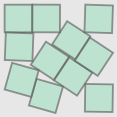

In [195]:
# Show the top n configs
amt = 10
print(f'Out of {len(df)} episodes, these are the top {amt}:')
# copy(str(df.filter(pl.col('valid')).head(amt)[1:amt]['episode'].to_numpy().tolist()))
display_df(df.filter(pl.col('valid') & (pl.col('side_len') < 4))[0], rnd=6)

In [199]:
display(
    round(3.920455 - 4, 3),
    round(3.920455 - 3.877084, 3)
)

-0.08

0.043

Episode 4723:
Side Length: 3.721573


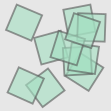

Episode 1100:
Side Length: 4.098353


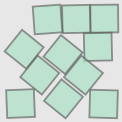

In [179]:
display_df(df.filter((~pl.col('valid')) & (pl.col('side_len') > ))[:10], rnd=6)

In [ ]:
df.filter(pl.col('valid') & (pl.col('side_len') < 4))[6]['config'][0].to_numpy()

array([1.6045002 , 4.261224  , 1.364817  , 2.6066422 , 4.003253  ,
       1.4243941 , 0.9940915 , 1.389026  , 1.3809589 , 2.0872374 ,
       2.2017298 , 0.07752558, 3.8678687 , 0.7987075 , 1.3654404 ,
       3.3107805 , 1.867319  , 0.4832412 , 1.4298679 , 3.269493  ,
       1.3778586 , 4.3748217 , 3.661359  , 1.3693848 , 3.0315716 ,
       2.8833907 , 0.4313028 , 2.3423557 , 1.1547815 , 1.5115314 ,
       4.259763  , 2.6476803 , 1.3913232 ], dtype=float32)

In [168]:
interesting = [2889, 3061, 3486, 3281, 4604, 2872, 2953, 3591, 3095, 2585, 2956, 2987, 2996, 3731, 2312, 4351, 3845, 2916, 4181, 2849, 845, 3568, 2554, 3968, 2512, 677, 714, 2813, 4553, 3550, 2913, 1106, 4117, 2814, 2129, 806]
these = df.filter(pl.col('episode').is_in(interesting)).sort('side_len')
# copy(str((these['episode'].to_list()))[1:-1])
a = these['side_len']
a = a.to_pandas()
a.to_clipboard()

Episode 4553:
Side Length: 3.92


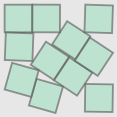

Episode 3550:
Side Length: 3.947


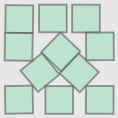

Episode 2913:
Side Length: 3.949


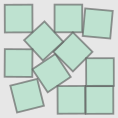

Episode 1106:
Side Length: 3.951


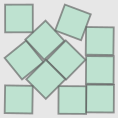

Episode 4117:
Side Length: 3.952


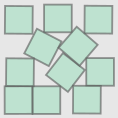

Episode 2814:
Side Length: 3.953


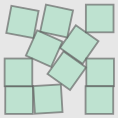

Episode 2129:
Side Length: 3.955


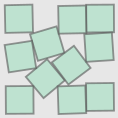

Episode 806:
Side Length: 3.957


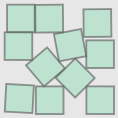

Episode 2889:
Side Length: 3.959


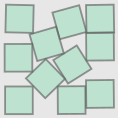

Episode 3061:
Side Length: 3.96


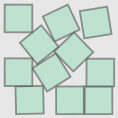

Episode 3486:
Side Length: 3.961


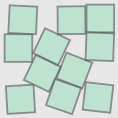

Episode 4604:
Side Length: 3.964


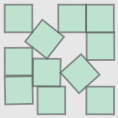

Episode 2554:
Side Length: 3.967


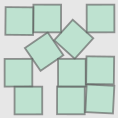

Episode 2512:
Side Length: 3.972


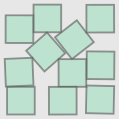

Episode 3968:
Side Length: 3.977


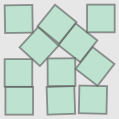

Episode 2872:
Side Length: 3.978


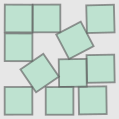

Episode 3845:
Side Length: 3.98


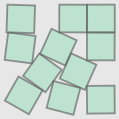

Episode 3095:
Side Length: 3.982


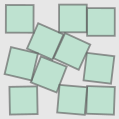

Episode 2585:
Side Length: 3.982


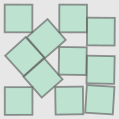

Episode 2987:
Side Length: 3.983


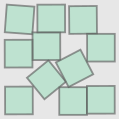

Episode 3568:
Side Length: 3.984


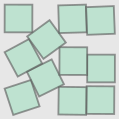

Episode 2956:
Side Length: 3.984


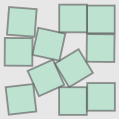

Episode 3591:
Side Length: 3.984


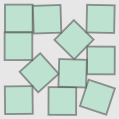

Episode 2849:
Side Length: 3.985


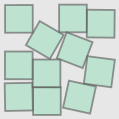

Episode 3281:
Side Length: 3.987


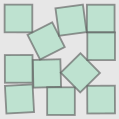

Episode 845:
Side Length: 3.989


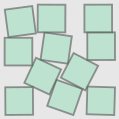

Episode 4181:
Side Length: 3.99


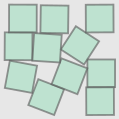

Episode 2953:
Side Length: 3.99


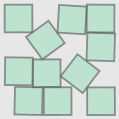

Episode 4351:
Side Length: 3.991


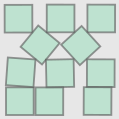

Episode 2916:
Side Length: 3.993


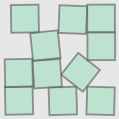

Episode 2996:
Side Length: 3.994


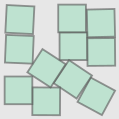

Episode 2312:
Side Length: 3.999


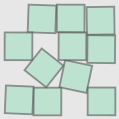

Episode 3731:
Side Length: 4.0


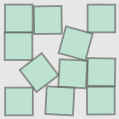

Episode 677:
Side Length: 4.002


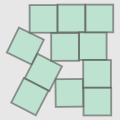

Episode 714:
Side Length: 4.002


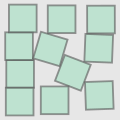

Episode 2813:
Side Length: 4.091


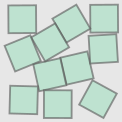

In [162]:

display_df(these)

In [ ]:
import cairosvg
from SquareEnv2 import space2MultiPolygon
import numpy as np
import math
from PIL import Image
import io
import shapely as shp
from numpy import deg2rad
import re

A = .000000000000001
scale = 30
margin = 10

def shapely2png(shapely, img_size, dx=margin/2, dy=margin/2):
    svg = shapely.svg(fill_color='#A3E0C2')
    svg = f'<svg xmlns="http://www.w3.org/2000/svg" width="{img_size+margin}" height="{img_size+margin}"><g transform="scale(1, -1) translate({dx}, -{img_size+dy})">{svg}</g></svg>'
    return Image.open(io.BytesIO(cairosvg.svg2png(bytestring=svg, background_color='#e7e7e7', output_height=img_size, output_width=img_size)))

In [ ]:
def parse_state(state, side_len=True, svg=True, image=True, dx=0, dy=0, size=None):
    if type(state) is str:
        try:
            state = eval(re.sub(r'(?<!\[)\s+', ',', state))
        except Exception as err:
            raise Exception(f'Failed to parse\n`{state}`') from err
    data = np.array(state).reshape((int(len(state)/3),3))
    x, y = space2MultiPolygon(data).minimum_rotated_rectangle.exterior.coords.xy
    edge_length = (shp.Point(x[0], y[0]).distance(shp.Point(x[1], y[1])), shp.Point(x[1], y[1]).distance(shp.Point(x[2], y[2])))
    _side_len = max(edge_length)
    if side_len:
        print(f'Side Length:', _side_len)

    rtn = data.copy()
    if svg:
        display(space2MultiPolygon(data))
    if image:
        data[:,0:2] *= scale
        display(shapely2png(space2MultiPolygon(data, side_len=scale), (_side_len if size is None else size) * scale, dx=dx+margin/2, dy=dy+margin/2))

    return rtn


In [ ]:
def display_df(df, *args, **kwargs):
    for row in df.iter_rows():
        print(f'Episode {row[0]}:')
        if 'image' not in kwargs:
            kwargs['image'] = False
        parse_state(row[4], *args, **kwargs)

In [ ]:
# Remove logs
remove = [1409]
remove = set(remove) - set()
remove = df.filter(pl.col('episode').is_in(remove))
display_df(remove)
if input('Continue?') == 'y':
    for i in remove['path']:
        os.remove(i)
    df = df.join(remove, how='anti', on='episode')
    display('erased!', clear=True)
else:
    display('canceled!', clear=True)

'erased!'

In [ ]:
df.filter(pl.col('episode') == 1409)

episode,side_len,path,valid,config,config_str
i64,f64,str,bool,list[f32],str
1409,3.956037,"""/home/zeke/hel…",true,"[0.612822, 0.560828, … 0.86938]","""0.61282211 0.5…"


In [ ]:
# Construct the best known configuration
A = .04
gap = .8+A
angle = np.deg2rad(90)-np.deg2rad(40.182)
side_len = 3.877084 + A*5
tiny_bottom_gap = .07
rot_half = .7014
# This is *not* the best known configuration, but it's pretty close, and then spread out enough to
# make it not overlap
almost_best_known = np.array([
    .5, .5, 0, # 3 in the bottom left
    1.5+A, .5, 0,
    .5, 1.5+A, 0,
    .5, side_len-.5, 0, # Top Left
    side_len-.5, side_len-.5, 0, # Top right
    2.5+A+tiny_bottom_gap, 0.5, 0, # Straight bottom rightish

    # Rotated
    side_len/2, side_len-rot_half, angle, # Top center
    side_len-rot_half+A, 1.56, angle, # Bottom rightmost
    side_len-rot_half*2+.2, 2.5, angle, # Middle upper right
    2.02, 1.78, angle, # Bottom center
    rot_half+.6, 2 + (side_len-3)/2, angle, # Left
])

In [ ]:
# *Attempting* to get all the configs that are too close to the already known best known solution
configs = np.vstack(df.filter('valid')['config'].to_numpy())
configs[:,2::3] *= 5/np.deg2rad(90)
not_mine = np.where(np.abs(np.sum(configs - almost_best_known, axis=1)) < 12)[0]
display_df(df.filter(pl.col('episode').is_in(not_mine)).head())

In [ ]:
# Open a specific log
select = 1238
subprocess.run(['code', '--reuse-window', df.filter(pl.col('episode') == select)['path'].to_list()[0]])
display('', clear=True)

''